In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
import numpy as np

In [3]:
df = pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Silver_Data.csv", index_col='Date')

In [4]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
06/09/2023,24.410,24.360,24.620,24.280,63.77K,0.25%
06/08/2023,24.348,23.525,24.460,23.510,84.07K,3.48%
06/07/2023,23.529,23.675,24.165,23.480,73.33K,-0.60%
06/06/2023,23.670,23.665,23.870,23.410,44.28K,0.15%
06/05/2023,23.635,23.690,23.785,23.320,47.49K,-0.47%
...,...,...,...,...,...,...
12/07/2017,15.753,15.965,15.965,15.630,0.03K,-1.04%
12/06/2017,15.918,16.090,16.095,15.940,0.03K,-0.71%
12/05/2017,16.032,16.345,16.345,16.055,0.09K,-1.87%



# Preprocessing Data

---





In [5]:
# Drop column that aren't use
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()

# Flip the column
df = df.iloc[::-1]

In [6]:
# Check if data still contain null values
df.isnull().sum()

Price    0
dtype: int64

In [7]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')


In [8]:
df

,Price
Date,
2017-12-01,16.354
2017-12-04,16.338
2017-12-05,16.032
2017-12-06,15.918
2017-12-07,15.753
...,...
2023-06-05,23.635
2023-06-06,23.670
2023-06-07,23.529


In [9]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "Date"

# Decompose

---



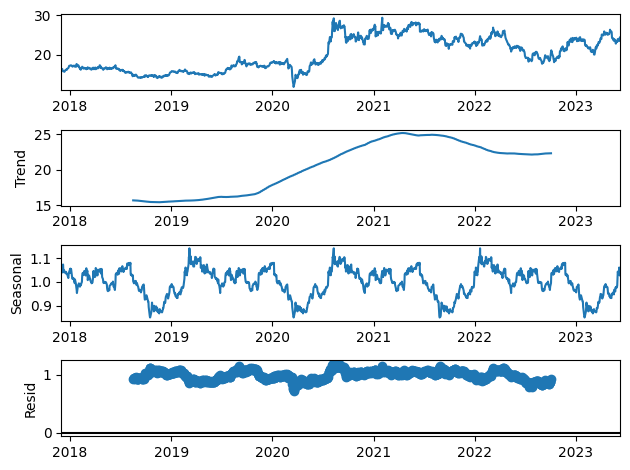

In [10]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

# Split dataset (7-2-1)

---



In [11]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.Price.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val.tail(len(val)))
  print('MAE: ', val_mae)

  val_value = val.Price.values
  pred_val_value = pred_val.tail(len(val)).values
  val_ape = np.abs((val_value - pred_val_value) / val_value)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val.tail(len(val)))
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [12]:
# Spilit data (7-2-1)
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

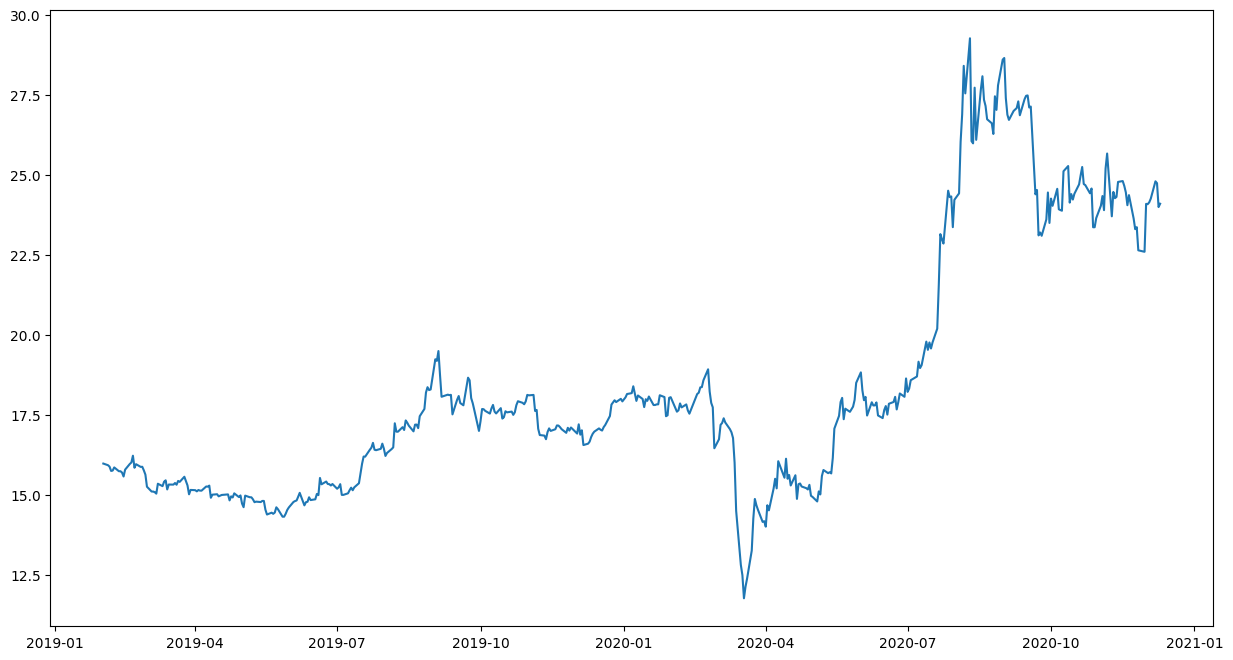

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['Price'][300:777]);

In [14]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=348, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


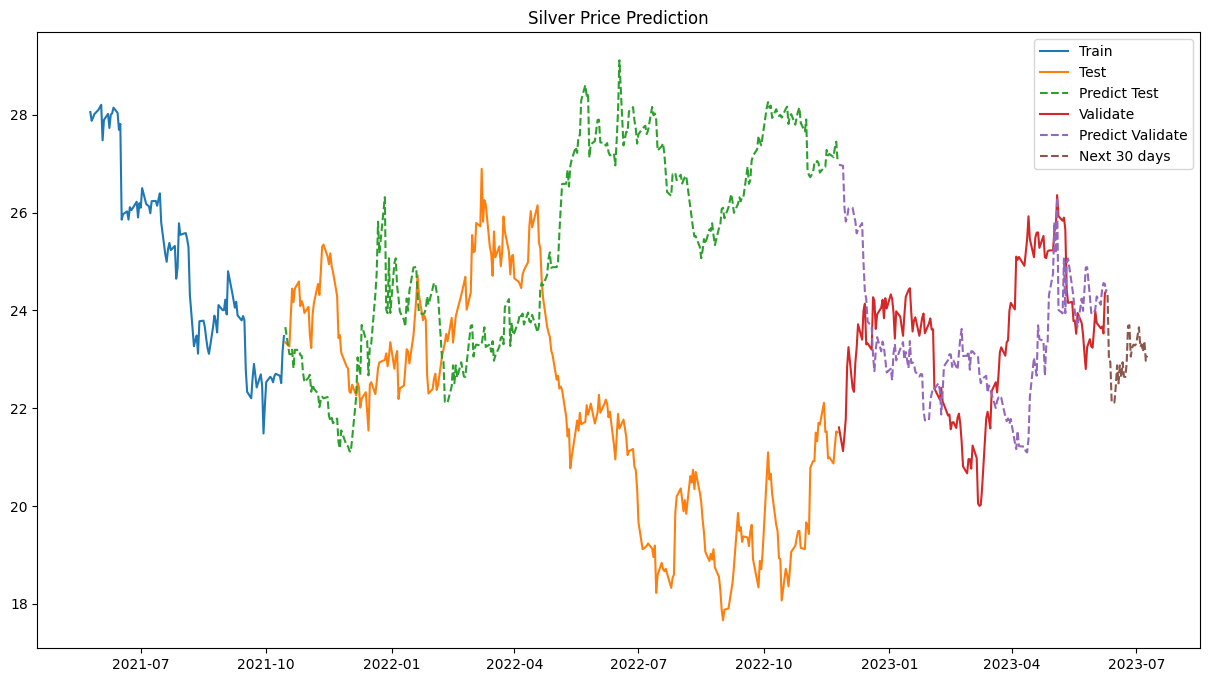

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Silver Price Prediction");

In [17]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  4.303474470856651
MAPE:  21.019066226259405
RMSE:  5.212335680474701

** Validate **
MAE:  1.502789377670774
MAPE:  6.470281167172702
RMSE:  1.9108408199829836


In [18]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  989
Model:             ExponentialSmoothing   SSE                            101.754
Optimized:                         True   AIC                          -1543.117
Trend:                   Multiplicative   BIC                            185.416
Seasonal:                Multiplicative   AICC                         -1143.812
Seasonal Periods:                   348   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         12:44:17
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8791606                alpha                 True
smoothing_trend       

# Split dataset (6-3-1)

---

In [19]:
# Spilit data (6-3-1)
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [20]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=298, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


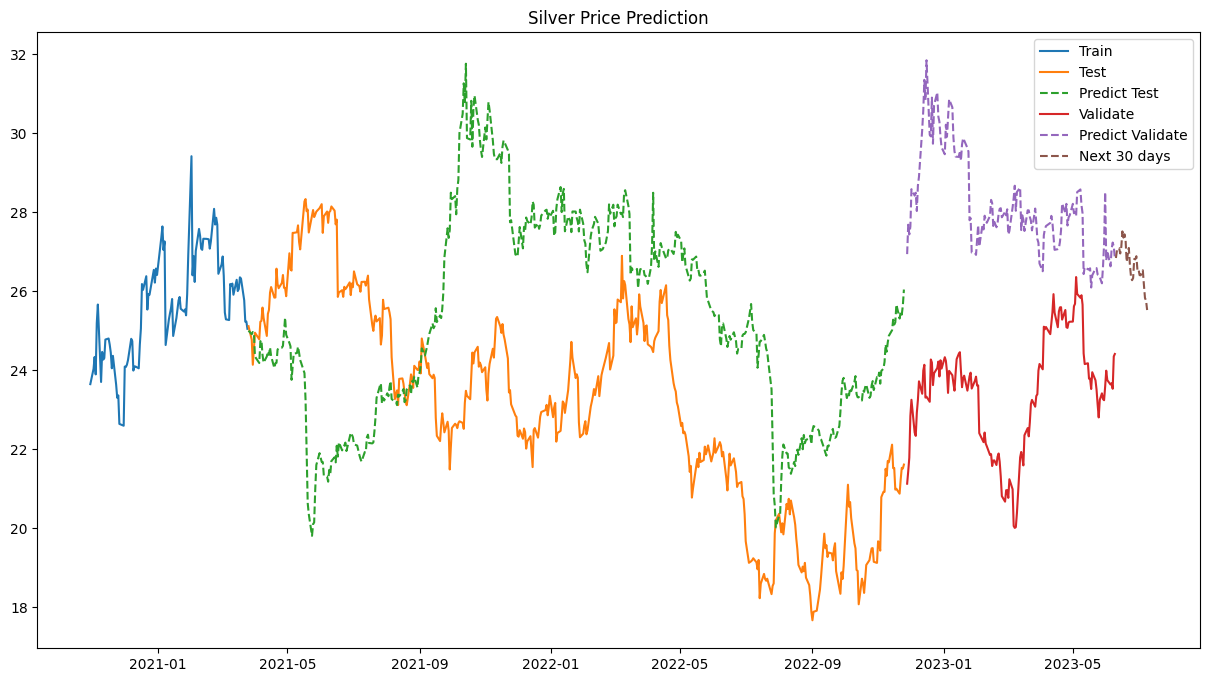

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Silver Price Prediction");

In [23]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  3.6316907715091133
MAPE:  16.06406146839245
RMSE:  4.088868329454211

** Validate **
MAE:  4.7244494181939825
MAPE:  20.585026373686564
RMSE:  5.067753922802181


In [24]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  848
Model:             ExponentialSmoothing   SSE                             89.176
Optimized:                         True   AIC                          -1303.921
Trend:                   Multiplicative   BIC                            133.172
Seasonal:                Multiplicative   AICC                          -959.529
Seasonal Periods:                   298   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         12:44:30
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8599430                alpha                 True
smoothing_trend       

# Split Dataset (5-3-2)

---



In [25]:
# Spilit data (5-3-2)
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [26]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=249, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


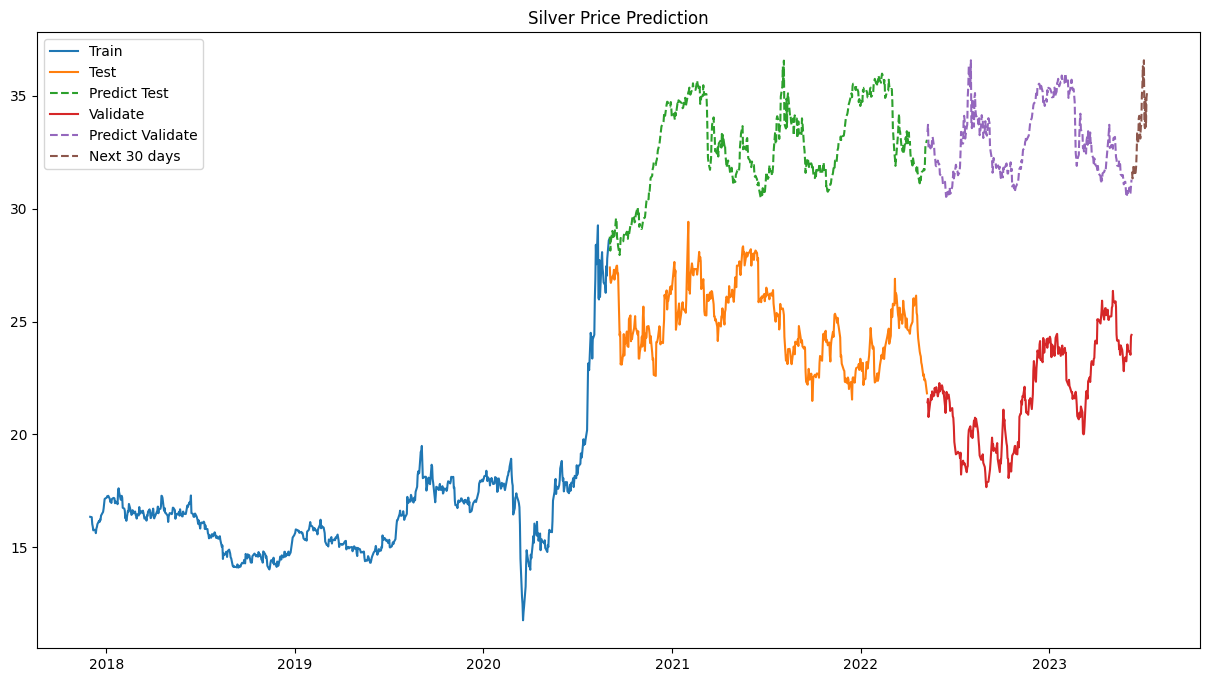

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Silver Price Prediction");

In [29]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  7.853035206447204
MAPE:  32.170185007194696
RMSE:  8.295275122831482

** Validate **
MAE:  11.22119823332338
MAPE:  52.92721380123595
RMSE:  11.486647425682252


In [30]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  707
Model:             ExponentialSmoothing   SSE                             49.040
Optimized:                         True   AIC                          -1378.555
Trend:                   Multiplicative   BIC                           -220.053
Seasonal:                Multiplicative   AICC                         -1086.146
Seasonal Periods:                   249   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         12:44:38
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9061522                alpha                 True
smoothing_trend       

# EVALUATING MODEL

---

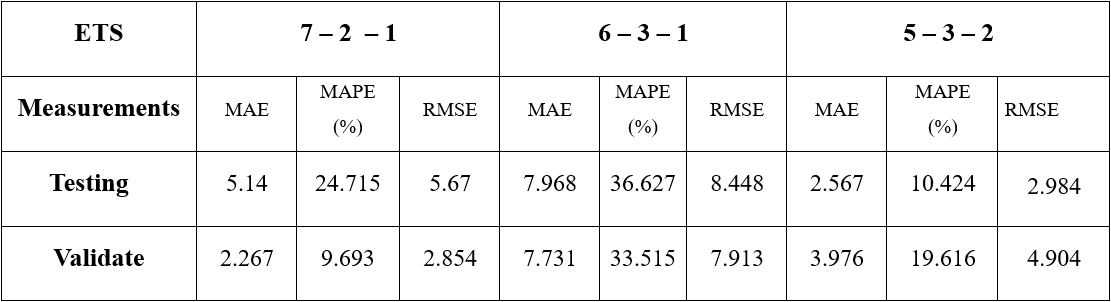